In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.optimize as opt
import copy
np.set_printoptions(threshold=np.inf, suppress=True, formatter={'float': '{: 0.8f}'.format}, linewidth=75)
%matplotlib inline

In [3]:
def kron(A, B):
    return la.kron(A, B)

In [4]:
def kronsum(A, B):
    if A.shape[0] != A.shape[1]:
        raise ValueError('A is not square')

    if B.shape[0] != B.shape[1]:
        raise ValueError('B is not square')
    
    L = kron(A, np.eye(B.shape[0]))
    R = kron(np.eye(A.shape[0]), B)
    
    return L+R

In [4]:
n = 3                   # Количество матриц D_k
p_num = 150             # Количество векторов стац. вероятн. p
eps_G = 10 ** (-6)      # Точность нахождения матр. G
eps_Phi = 10 ** (-6)    # Точность нахождения матр. Phi
eps_p_i = 10 ** (-6)    # Точность нахождения векторов p

In [5]:
# Входной BMAP
matrD_0 = np.array([[-86., 0.01], [0.02, -2.76]]) * 0.025
matrD = np.array([[85, 0.99], [0.2, 2.54]]) * 0.025
matrD_k = [matrD_0]

W_ = matrD_0.shape[0]
W = W_ - 1

q = 0.8
for k in range(1, n+1):
    matrD_k.append(matrD * (q ** (k-1)) * (1 - q) / (1 - q ** 3))

for matr in matrD_k:
    print(matr)

[[-2.15000000  0.00025000]
 [ 0.00050000 -0.06900000]]
[[ 0.87090164  0.01014344]
 [ 0.00204918  0.02602459]]
[[ 0.69672131  0.00811475]
 [ 0.00163934  0.02081967]]
[[ 0.55737705  0.00649180]
 [ 0.00131148  0.01665574]]


In [6]:
# Характеристики входного BMAP

matrD_1_ = np.zeros(matrD_k[0].shape)
for matr in matrD_k:
    matrD_1_ += matr
print('matrD_1_ =', matrD_1_)
matr_a = np.array(copy.deepcopy(matrD_1_))
for i in range(matr_a.shape[0]):
    matr_a[i][0] = 1

matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1

matr_a = np.transpose(matr_a)

theta = la.solve(matr_a, matr_b).reshape(-1)    # Алгоритм проверен.

matrdD_1_ = np.array(copy.deepcopy(matrD_k[1]))

print('Theta =', theta)

for i in range(2, n+1):
    matrdD_1_ += matrD_k[i] * i
vect_e = np.array([[1.] for i in range(0, matrD_1_.shape[0])])
lamD = np.dot(np.dot(theta, matrdD_1_), vect_e)
print('lambda =', lamD[0])

matrD_1_ = [[-0.02500000  0.02500000]
 [ 0.00550000 -0.00550000]]
Theta = [ 0.18032787  0.81967213]
lambda = 0.822134977157


In [7]:
# Поток поломок MAP
matrH0 = np.array([[-8.110725, 0], [0, -0.26325]]) / 3
matrH1 = np.array([[8.0568, 0.053925], [0.146625, 0.116625]]) / 3
V_ = matrH1.shape[0]
V = V_ - 1
matrH = matrH0 + matrH1
matr_a = copy.deepcopy(matrH)
for i in range(matr_a.shape[0]):
    # print(matr_a)
    matr_a[i][0] = 1
    
matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1

matr_a = np.transpose(matr_a)

print('H_0 =', matrH0)
print('H_1 =', matrH1)

gamma = la.solve(matr_a, matr_b).reshape(-1)

vect_e = np.array([[1.] for i in range(0, matrD_1_.shape[0])])
h = np.dot(np.dot(gamma, matrH1), vect_e)
print('h =', h[0])

H_0 = [[-2.70357500  0.00000000]
 [ 0.00000000 -0.08775000]]
H_1 = [[ 2.68560000  0.01797500]
 [ 0.04887500  0.03887500]]
h = 2.00021741773


In [8]:
# Поток обслуживания PH1
beta1 = np.array([[1, 0]])
matrS1 = np.array([[-20, 20], [0, -20]])
M1 = matrS1.shape[0]
M1_ = M1 + 1
M1_e = np.array([[1], [1]])
matrS1_0 = np.dot(- matrS1, M1_e)
vect_e = np.array([[1.] for i in range(0, matrS1.shape[0])])
# print(np.dot(beta1, la.inv(matrS1)))
mu_1 = -la.inv(np.dot(np.dot(beta1, la.inv(matrS1)), vect_e))
print(mu_1)

[[ 10.00000000]]


In [9]:
# Поток обслуживания PH2
beta2 = np.array([[1, 0]])
matrS2 = np.array([[-2, 2], [0, -2]])
M2 = matrS2.shape[0]
M2_ = M2 + 1
M2_e = np.array([[1], [1]])
matrS2_0 = np.dot(- matrS2, M2_e)

vect_e = np.array([[1.] for i in range(0, matrS2.shape[0])])
mu_2 = -la.inv(np.dot(np.dot(beta2, la.inv(matrS2)), vect_e))
print(mu_2)

[[ 1.00000000]]


In [10]:
matrS_w = kron(np.dot(matrS1_0, beta1), 
               np.dot(M2_e, beta2)) + kron(np.dot(M1_e, beta1), np.dot(matrS2_0, beta2))

In [11]:
# Поток переключения с прибора-1 на прибор-2
alpha1 = np.array([[0.05, 0.95]])
matrA1 = np.array([[-1.86075, 0.], [0., -146.9994]])
L1 = matrA1.shape[0]
L1_ = L1 + 1
L1_e = np.array([[1], [1]])
matrA1_0 = - np.dot(matrA1, L1_e)

vect_e = np.array([[1.] for i in range(0, matrA1.shape[0])])
kappa_1 = -la.inv(np.dot(np.dot(alpha1, la.inv(matrA1)), vect_e))
print(kappa_1)

[[ 29.99985287]]


In [12]:
# Поток переключения с прибора-2 на прибор-1
alpha2 = np.array([[0.05, 0.95]])
matrA2 = np.array([[-5.58225, 0.], [0., -440.9982]])
L2 = matrA2.shape[0]
L2_ = L2 + 1
L2_e = np.array([[1], [1]])
matrA2_0 = - np.dot(matrA2, L2_e)

vect_e = np.array([[1.] for i in range(0, matrA1.shape[0])])
kappa_2 = -la.inv(np.dot(np.dot(alpha2, la.inv(matrA2)), vect_e))
print(kappa_2)

[[ 89.99955862]]


In [13]:
# Поток ремонта PH
tau = np.array([[0.98, 0.02]])
matrT = np.array([[-100., 0.], [0., -0.0002]])
T_e = np.array([[1], [1]])
matrT0 = - np.dot(matrT, T_e)

R = matrT.shape[0]
R_ = R + 1
vect_e = np.array([[1.] for i in range(0, matrT.shape[0])])
phi = -np.dot(np.dot(tau, la.inv(matrT)), vect_e)
print(phi)

[[ 100.00980000]]


In [14]:
a = W_ * V_
print('a =', a)

a = 4


In [15]:
# Q~0
block00 = kronsum(matrD_k[0], matrH0)
block03 = kron(kron(kron(np.eye(W_), matrH1), tau), alpha1)
block10 = kron(np.eye(a), matrA2_0)
block11 = kronsum(kronsum(matrD_k[0], matrH0), matrA2)
block12 = kron(kron(kron(np.eye(W_), matrH1), tau), L2_e)
block21 = kron(kron(np.eye(a), matrT0), alpha2)
block22 = kronsum(kronsum(matrD_k[0], matrH), matrT)
block30 = kron(kron(np.eye(a), matrT0), L1_e)
block32 = kron(kron(np.eye(a), np.eye(R)), matrA1_0)
block33 = kronsum(kronsum(kronsum(matrD_k[0], matrH), matrT), matrA1)
block01 = np.zeros((block00.shape[0], block11.shape[1]))
block02 = np.zeros((block00.shape[0], block12.shape[1]))
block13 = np.zeros((block10.shape[0], block03.shape[1]))
block20 = np.zeros((block21.shape[0], block10.shape[1]))
block23 = np.zeros((block21.shape[0], block03.shape[1]))
block31 = np.zeros((block30.shape[0], block11.shape[1]))

print(block30.shape)

matrQw_0 = np.bmat([[block00, block01, block02, block03],
                    [block10, block11, block12, block13], 
                    [block20, block21, block22, block23],
                    [block30, block31, block32, block33]])
print(matrQw_0.shape)

(16, 4)
(36, 36)


In [16]:
# Q~k
matrQw_k = [matrQw_0]
for i in range(1, n+1):
    block0 = kron(kron(matrD_k[i], np.eye(V_)), beta1)
    block1 = kron(kron(kron(matrD_k[i], np.eye(V_)), beta2), np.eye(L2))
    block2 = kron(kron(kron(matrD_k[i], np.eye(V_)), beta2), np.eye(R))
    block3 = kron(kron(matrD_k[i], np.eye(V_)), np.eye(R*L1))
    matr_temp = la.block_diag(block0, block1, block2, block3)
    matrQw_k.append(matr_temp)
    
print(matrQw_k[0].shape)
print(matrQw_k[1].shape)

for i in range(matrQw_k[0].shape[0]):
    sum = 0
    for matr in matrQw_k:
        sum += np.sum(matr[i])
    # print('matrQw_k[' + str(i) + '] = ', sum)

(36, 36)
(36, 56)


In [17]:
# Q^0
block0 = kron(np.eye(a), matrS1_0)
block1 = kron(kron(np.eye(a), matrS2_0), np.eye(L2))
block2 = kron(kron(np.eye(a), matrS2_0), np.eye(R))
block3 = np.zeros((a*R*L1, a*R*L1))
matrQv_0 = la.block_diag(block0, block1, block2, block3)

print(matrQv_0.shape)

(56, 36)


In [18]:
# Q_0
block0 = kron(np.eye(a), np.dot(matrS1_0, beta1))
block1 = kron(kron(np.eye(a), np.dot(matrS2_0, beta2)), np.eye(L2))
block2 = kron(kron(np.eye(a), np.dot(matrS2_0, beta2)), np.eye(R))
block3 = np.zeros((a*R*L1, a*R*L1))
matrQ_0 = la.block_diag(block0, block1, block2, block3)

print(matrQ_0.shape)

(56, 56)


In [19]:
# Q_1
block00 = kronsum(kronsum(matrD_k[0], matrH0), matrS1)
block03 = kron(kron(kron(kron(np.eye(W_), matrH1), M1_e), tau), alpha1)
block10 = kron(kron(kron(np.eye(a), M2_e), beta1), matrA2_0)
block11 = kronsum(kronsum(kronsum(matrD_k[0], matrH0), matrS2), matrA2)
block12 = kron(kron(kron(kron(np.eye(W_), matrH1), np.eye(M2)), tau), L2_e)
block21 = kron(kron(kron(np.eye(a), np.eye(M2)), matrT0), alpha1)
block22 = kronsum(kronsum(kronsum(matrD_k[0], matrH), matrS2), matrT)
block30 = kron(kron(kron(np.eye(a), beta1), matrT0), L1_e)
block32 = kron(kron(kron(np.eye(a), beta2), np.eye(R)), matrA1_0)
block33 = kronsum(kronsum(kronsum(matrD_k[0], matrH), matrT), matrA1)
block01 = np.zeros((block00.shape[0], block11.shape[1]))
block02 = np.zeros((block00.shape[0], block12.shape[1]))
block13 = np.zeros((block10.shape[0], block03.shape[1]))
block20 = np.zeros((block21.shape[0], block10.shape[1]))
block23 = np.zeros((block21.shape[0], block03.shape[1]))
block31 = np.zeros((block30.shape[0], block11.shape[1]))

matrQ_1 = np.bmat([[block00, block01, block02, block03], 
                   [block10, block11, block12, block13], 
                   [block20, block21, block22, block23], 
                   [block30, block31, block32, block33]])

print(matrQ_1.shape)

(56, 56)


In [21]:
matrQ_k = [matrQ_0, matrQ_1]
for k in range(2, n+2):
    block0 = kron(matrD_k[k-1], np.eye(V_ * M1))
    block1 = kron(matrD_k[k-1], np.eye(V_*M2*L2))
    block2 = kron(matrD_k[k-1], np.eye(V_*M2*R))
    block3 = kron(matrD_k[k-1], np.eye(V_*R*L1))
    matr_temp = la.block_diag(block0, block1, block2, block3)
    matrQ_k.append(matr_temp)

# for i in range(matrQ_k[0].shape[0]):
#     sum = np.sum(matrQv_0[i])
#     for j in range(1, np.array(matrQ_k).shape[0]):
#         sum += np.sum(matrQ_k[j][i])
#     print('matrQ_k[' + str(i) + '] = ', sum)

In [22]:
# Проверка генератора Q

In [22]:
# Поиск матрицы G

matrQ_1_neg_inv = np.linalg.inv(-matrQ_k[1])


def calc_G(matrG_prev):
    temp_sum = np.array(copy.deepcopy(matrQ_k[0])) 
    for k in range(2, n + 2):
        temp_sum += np.dot(matrQ_k[k], np.linalg.matrix_power(matrG_prev, k))
    matrG_new = np.dot(matrQ_1_neg_inv, temp_sum)
    return matrG_new

matrG_old = np.eye(matrQ_k[1].shape[0])
matrG = calc_G(matrG_old)

i = 1
while la.norm(matrG - matrG_old, ord=np.inf) >= eps_G:
    matrG_old = matrG
    matrG = calc_G(matrG_old)
    i += 1
print(i)
print(la.norm(matrG, ord=np.inf))
print(matrG.shape)

722
1.0000000000000009
(56, 56)


In [24]:
la.norm(matrG, ord=np.inf)

1.0000000000000009

In [25]:
temp_sum = np.array(copy.deepcopy(matrQ_k[1]))
for k in range(2, n+2):
    temp_sum += np.dot(matrQ_k[k], np.linalg.matrix_power(matrG, k-1))
matrG_0 = la.inv(temp_sum)
matrG_0 = -np.dot(matrG_0, matrQv_0)
# pd.DataFrame(matrG_0)
la.norm(matrG_0, ord=np.inf)

1.000000000000001

In [26]:
matrQ_il = []
for i in range(0, p_num):
    matrQ_il.append([])
    if i == 0:
        for l in range(0, n + 1):
            # здесь до n, т.к. нет больше матриц Q_k
            temp_matr = np.array(copy.deepcopy(matrQw_k[l]))
            for k in range(l + 1, n + 1):
                mult_matr = np.array(copy.deepcopy(matrQw_k[k]))
                for kk in range(k - 1, l - 1, -1):
                    if kk == 0:
                        mult_matr = np.dot(mult_matr, matrG_0)
                    else:
                        mult_matr = np.dot(mult_matr, matrG)
                print("mult matr 0 shape : ", mult_matr.shape)
                temp_matr += mult_matr
            matrQ_il[i].append(temp_matr)
        for l in range(n + 1, p_num):
            matrQ_il[i].append(np.zeros(matrQw_k[1].shape))
    else:
        for l in range(0, p_num):
            if l >= i and (l - i) <= (n + 1):
                if (l - i + 1) <= (n + 1): 
                    temp_matr = np.array(copy.deepcopy(matrQ_k[l - i + 1]))
                else:
                    temp_matr = np.zeros(matrQ_k[0].shape)
                    
                for k in range(l + 1, p_num):  # sum from l+1 to inf
                    if (k - i + 1) <= (n + 1):
                        mult_matr = np.array(copy.deepcopy(matrQ_k[k - i + 1]))
                        for kk in range(l, k):
                            mult_matr = np.dot(mult_matr, matrG)
                        
                        temp_matr += mult_matr
                matrQ_il[i].append(temp_matr)
            else:
                matrQ_il[i].append(np.zeros(matrQ_k[0].shape))

# print(len(matrQ_il[3]))
print(la.norm(matrQ_il[1][3], ord=np.inf))

mult matr 0 shape :  (36, 36)
mult matr 0 shape :  (36, 36)
mult matr 0 shape :  (36, 36)
mult matr 0 shape :  (36, 56)
mult matr 0 shape :  (36, 56)
mult matr 0 shape :  (36, 56)


1.2687049180327876


In [27]:
matrPhi_0 = np.eye(matrQ_il[0][0].shape[0])
matrPhi_l = [matrPhi_0]
for l in range(1, p_num):
    temp_matr = np.dot(np.dot(matrPhi_l[0], matrQ_il[0][l]), la.inv(-matrQ_il[l][l]))
    for i in range(1, l):
        # print(matrPhi_l[i].dot(matrQ_il[i][l]).dot(la.inv(-matrQ_il[l][l])).shape)
        temp_matr += np.dot(np.dot(matrPhi_l[i], matrQ_il[i][l]), la.inv(-matrQ_il[l][l]))
    matrPhi_l.append(temp_matr)
print(matrPhi_l[1].shape)

(36, 56)


In [28]:
print(la.norm(matrPhi_l[p_num - 1], ord=np.inf))

0.3507955515344994


In [29]:
# Вычисление p_0
matr_a = np.array(- copy.deepcopy(matrQ_il[0][0]))
vect_eaR = np.array([[1.] for _ in range(matrPhi_l[0].shape[1])])
for i in range(1, p_num):
    vect_e = np.array([[1.] for _ in range(matrPhi_l[i].shape[1])])
    vect_eaR += np.dot(matrPhi_l[i], vect_e)

for i in range(matr_a.shape[0]):
    matr_a[i][0] = vect_eaR[i][0]

matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1.
matr_a = np.transpose(matr_a)
p0 = np.transpose(la.solve(matr_a, matr_b))

# print(p0)
print(p0)

[[ 0.00028866  0.00024923  0.00339559  0.00250656  0.00000209  0.00000092
   0.00000005  0.00000002  0.00003174  0.00001135  0.00000099  0.00000024
   0.00000432  0.00022324  0.00000008  0.00007859  0.00005236  0.32159745
   0.00000090  0.11742620  0.00000037  0.00000294  0.00000020  0.00000010
   0.00000001  0.00000006  0.00000000  0.00000000  0.00000444  0.00003482
   0.00000475  0.00000119  0.00000008  0.00000060  0.00000012  0.00000002]]


In [30]:
vect_p_l = [p0]
p_sums = [np.sum(p0)]
print('p0 = ', vect_p_l[0][0])
print('sum0 = ', p_sums[0])
for l in range(1, p_num):
    vect_p_l.append(np.dot(vect_p_l[0], matrPhi_l[l]))
    p_sums.append(np.sum(vect_p_l[l]))
    # print('p' + str(l) + ' = ', vect_p_l[l][0])
    print('sum' + str(l) + ' = ', p_sums[l])
print('sum = ', np.sum(p_sums))

p0 =  [ 0.00028866  0.00024923  0.00339559  0.00250656  0.00000209  0.00000092
  0.00000005  0.00000002  0.00003174  0.00001135  0.00000099  0.00000024
  0.00000432  0.00022324  0.00000008  0.00007859  0.00005236  0.32159745
  0.00000090  0.11742620  0.00000037  0.00000294  0.00000020  0.00000010
  0.00000001  0.00000006  0.00000000  0.00000000  0.00000444  0.00003482
  0.00000475  0.00000119  0.00000008  0.00000060  0.00000012  0.00000002]
sum0 =  0.445920293286
sum1 =  0.0315344460749
sum2 =  0.021998064213
sum3 =  0.0133535056575
sum4 =  0.00542012933236
sum5 =  0.00457198676093
sum6 =  0.00414599864288
sum7 =  0.00397447522635
sum8 =  0.00393498999616
sum9 =  0.0039129108343
sum10 =  0.00389911849871
sum11 =  0.00388905095858
sum12 =  0.0038793245632
sum13 =  0.00386997168477
sum14 =  0.00386080170173
sum15 =  0.00385165150022
sum16 =  0.00384255380707
sum17 =  0.00383348761736
sum18 =  0.00382444378025
sum19 =  0.00381542487414
sum20 =  0.00380642810151
sum21 =  0.00379745290682
s

 0.00350458470072
sum56 =  0.00349632172365
sum57 =  0.00348807822836
sum58 =  0.00347985416894
sum59 =  0.00347164949957
sum60 =  0.00346346417454
sum61 =  0.00345529814826
sum62 =  0.00344715137522
sum63 =  0.00343902381006
sum64 =  0.00343091540747
sum65 =  0.00342282612231
sum66 =  0.00341475590949
sum67 =  0.00340670472407
sum68 =  0.00339867252118
sum69 =  0.00339065925608
sum70 =  0.00338266488412
sum71 =  0.00337468936077
sum72 =  0.00336673264159
sum73 =  0.00335879468226
sum74 =  0.00335087543855
sum75 =  0.00334297486633
sum76 =  0.0033350929216
sum77 =  0.00332722956044
sum78 =  0.00331938473904
sum79 =  0.00331155841369
sum80 =  0.0033037505408
sum81 =  

0.00329596107685
sum82 =  0.00328818997845
sum83 =  0.00328043720231
sum84 =  0.00327270270523
sum85 =  0.00326498644411
sum86 =  0.00325728837597
sum87 =  0.00324960845792
sum88 =  0.00324194664716
sum89 =  0.00323430290101
sum90 =  0.00322667717688
sum91 =  0.00321906943228
sum92 =  0.00321147962483
sum93 =  0.00320390771224
sum94 =  0.00319635365231
sum95 =  0.00318881740297
sum96 =  0.00318129892222
sum97 =  0.00317379816817
sum98 =  0.00316631509902
sum99 =  0.00315884967309
sum100 =  0.00315140184878
sum101 =  0.0031439715846
sum102 =  0.00313655883913
sum103 =  0.00312916357109
sum104 =  0.00312178573926
sum105 =  0.00311442530254
sum106 =  0.00310708221992
sum107 =  0.00309975645047
sum108 =  0.0030924479534
sum109 =  0.00308515668796
sum110 =  0.00307788261355
sum111 =  0.00307062568962
sum112 =  0.00306338587574
sum113 =  0.00305616313157
sum114 =  0.00304895741688
sum115 =  0.0030417686915
sum116 =  0.00303459691539
sum117 =  0.00302744204858
sum118 =  0.00302030405121
sum11

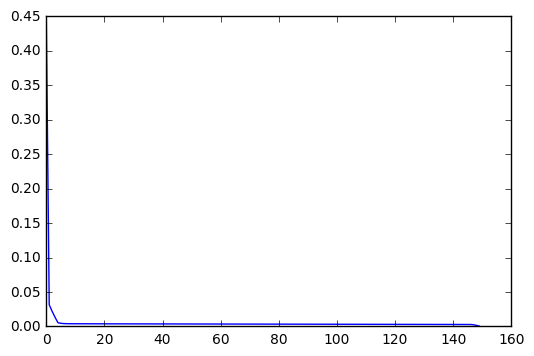

[0.44592029328596866, 0.031534446074859043, 0.021998064213027448, 0.01335350565747628, 0.0054201293323584976, 0.0045719867609342307, 0.0041459986428762485, 0.0039744752263468587, 0.0039349899961619861, 0.0039129108342996401, 0.0038991184987134278, 0.0038890509585767668, 0.0038793245632047411, 0.0038699716847682437, 0.0038608017017334488, 0.0038516515002232701, 0.0038425538070695851, 0.0038334876173635865, 0.003824443780252474, 0.0038154248741431793, 0.0038064281015069172, 0.0037974529068209627, 0.0037884992729924349, 0.0037795668346151433, 0.0037706555112842991, 0.0037617652306060657, 0.0037528959131074482, 0.0037440475080862293, 0.0037352199631012421, 0.0037264132275606362, 0.0037176272531343106, 0.0037088619911619055, 0.0037001173932791698, 0.0036913934112275271, 0.0036826899967188822, 0.0036740071015238743, 0.0036653446774589479, 0.0036567026764001069, 0.0036480810503018127, 0.0036394797512040076, 0.0036308987312404146, 0.0036223379426442472, 0.003613797337751746, 0.0036052768690048

In [54]:
plt.plot(p_sums)
plt.show()
print(p_sums)

In [32]:
matr_Q_1_ = copy.deepcopy(matrQ_k[0])
for l in range(1, n+2):
    matr_Q_1_ += matrQ_k[l]

In [33]:
matr_dQ_1_ = copy.deepcopy(matrQ_k[1])
for l in range(2, n+2):
    matr_dQ_1_ += l * matrQ_k[l]

In [34]:
matr_a = copy.deepcopy(np.array(matr_Q_1_))
for i in range(matr_a.shape[0]):
    matr_a[i][0] = 1 
matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1
matr_a = np.transpose(matr_a)

vect_y = la.solve(matr_a, matr_b).reshape(-1)

In [35]:
vect_e = np.array([[1.] for _ in range(matr_dQ_1_.shape[1])])
ergodicity = np.dot(np.dot(vect_y, matr_dQ_1_), vect_e) 
print('ergodicity =', ergodicity[0, 0])
 
sys_load = ergodicity + lamD
print('sys_load =', sys_load)

ergodicity = -0.228793196557
sys_load = [[ 0.59334178]]


In [36]:
# Условие эргодичности
block00 = kronsum(matrH0, matrS1) + kron(np.eye(V_), np.dot(matrS1_0, beta1))
block03 = kron(kron(kron(matrH1, M1_e), tau), alpha1)
block10 = kron(kron(np.eye(V_), np.dot(M2_e, beta1)), matrA2_0)
block11 = kronsum(kronsum(matrH0, matrS2), matrA2) + kron(kron(np.eye(V_), np.dot(matrS2_0, beta2)), np.eye(L2))
block12 = kron(kron(kron(matrH1, np.eye(M2)), tau), L2_e)
block21 = kron(kron(kron(np.eye(V_), np.eye(M2)), matrT0), alpha1)
block22 = kronsum(kronsum(matrH, matrS2), matrT) + kron(kron(np.eye(V_), np.dot(matrS2_0, beta2)), np.eye(R))
block30 = kron(kron(kron(np.eye(V_), beta1), matrT0), L1_e)
block32 = kron(kron(kron(np.eye(V_), beta2), np.eye(R)), matrA1_0)
block33 = kronsum(kronsum(matrH, matrT), matrA1)
block01 = np.zeros((block00.shape[0], block11.shape[1]))
block02 = np.zeros((block00.shape[0], block12.shape[1]))
block13 = np.zeros((block10.shape[0], block03.shape[1]))
block20 = np.zeros((block21.shape[0], block00.shape[1]))
block23 = np.zeros((block21.shape[0], block03.shape[1]))
block31 = np.zeros((block30.shape[0], block11.shape[1]))
matrGamma = np.bmat([[block00, block01, block02, block03],
                     [block10, block11, block12, block13],
                     [block20, block21, block22, block23],
                     [block30, block31, block32, block33]])
# pd.DataFrame(matrGamma)

In [37]:
matr_a = copy.deepcopy(np.array(matrGamma))
for i in range(matr_a.shape[0]):
    matr_a[i][0] = 1
matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1
matr_a = np.transpose(matr_a)

x = la.solve(matr_a, matr_b).reshape(-1)

print('x = ', x)
x1 = x[0:V_*M1]
x2 = x[V_*M1:V_*M1 + V_*M2*L2]
x3 = x[V_*M1 + V_*M2*L2: V_*M1 + V_*M2*L2 + V_*M2*R]

print('x1 = ', x1)
print('x2 = ', x2)
print('x3 = ', x3)

x =  [ 0.00188895  0.00166401  0.00119355  0.00118834  0.00002762  0.00001158
  0.00000632  0.00000047  0.00000085  0.00000024  0.00000041  0.00000006
  0.00005357  0.36373087  0.00000123  0.36368237  0.00000087  0.13325071
  0.00000002  0.13324969  0.00000465  0.00003640  0.00000514  0.00000125
  0.00000008  0.00000059  0.00000013  0.00000002]
x1 =  [ 0.00188895  0.00166401  0.00119355  0.00118834]
x2 =  [ 0.00002762  0.00001158  0.00000632  0.00000047  0.00000085  0.00000024
  0.00000041  0.00000006]
x3 =  [ 0.00005357  0.36373087  0.00000123  0.36368237  0.00000087  0.13325071
  0.00000002  0.13324969]


In [38]:
e_V_ = np.array([[1.] for i in range(0, V_)])
e_R = np.array([[1.] for i in range(0, R)])
pi1 = x1.dot(kron(e_V_, np.eye(M1)))
pi2 = x2.dot(kron(kron(e_V_, np.eye(M2)), L2_e))
pi3 = x3.dot(kron(kron(e_V_, np.eye(M2)), e_R))
print('pi1 = ', pi1)
print('pi2 = ', pi2)
print('pi3 = ', pi3)

pi1 =  [ 0.00308250  0.00285235]
pi2 =  [ 0.00004029  0.00000726]
pi3 =  [ 0.49703602  0.49693331]


In [39]:
rho = np.dot(pi1, matrS1_0) + np.dot((pi2 + pi3), matrS2_0)
print('rho = ', rho[0])

rho =  1.05092817371


In [40]:
vect_P_1_ = copy.deepcopy(vect_p_l[1])
for l in range(2, p_num):
    vect_P_1_ += vect_p_l[l]
print('P(1) =', vect_P_1_)

P(1) = [[ 0.00025713  0.00022632  0.00015932  0.00015847  0.00048395  0.00042647
   0.00027144  0.00027038  0.00000426  0.00000161  0.00000095  0.00000006
   0.00000013  0.00000003  0.00000005  0.00000001  0.00000738  0.00000300
   0.00000175  0.00000015  0.00000026  0.00000007  0.00000015  0.00000003
   0.00000743  0.04265181  0.00000017  0.04215565  0.00000012  0.01557542
   0.00000000  0.01539769  0.00001377  0.15949469  0.00000032  0.15954429
   0.00000021  0.05846079  0.00000000  0.05848465  0.00000064  0.00000498
   0.00000092  0.00000017  0.00000001  0.00000008  0.00000002  0.00000000
   0.00000119  0.00000932  0.00000149  0.00000032  0.00000002  0.00000014
   0.00000004  0.00000000]]

In [41]:
vect_dP_1_ = copy.deepcopy(vect_p_l[1])
for l in range(2, p_num):
    vect_dP_1_ += l * vect_p_l[l]

In [42]:
vect_ddP_1_ = copy.deepcopy(vect_p_l[2]) * 2
for l in range(3, p_num):
    vect_ddP_1_ += l * (l - 1) * vect_p_l[l]

In [43]:
# Среднее число запросов в системе

vect_e = np.array([[1.] for _ in range(vect_dP_1_.shape[1])])
L = np.dot(vect_dP_1_, vect_e)
print('L =', L[0, 0])

L = 34.8845584716


In [44]:
# Дисперсия числа запросов в системе
dispV = np.dot(vect_ddP_1_, vect_e)[0] + L - L ** 2
print('V =', dispV[0, 0])

V = 2115.23574869


In [46]:
# Вероятность того, что прибор-1 в неисправном состоянии и прибор-2 обслуживает запрос
temp_matr = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*M2*(L2 + R)), np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr.shape[1])])
prob1notwork = np.dot(temp_matr, vect_e)
print('P^{(2,0),(1,2)} =', prob1notwork[0, 0])

P^{(2,0),(1,2)} = 0.551806873862


In [47]:
# Вероятность того, что в системе есть запросы, прибор 1 в неисправном состоянии и идет переключение с этого прибора на прибор 2 (при этом оба  прибора не обслуживают заявки)
temp_matr = np.dot(vect_P_1_, la.block_diag(np.zeros((a*(M1+M2*(L2+R)), a*(M1+M2*(L2+R)))), np.eye(a*R*L1)))
vect_e = np.array([[1.] for i in range(0, temp_matr.shape[1])])
prob1notworkswitch2 = np.dot(temp_matr, vect_e)
print('P^{(2,1)} =', prob1notworkswitch2[0, 0])

P^{(2,1)} = 1.93566026111e-05


In [48]:
# Вероятность того, что в системе есть запросы, прибор 1 в исправном состоянии и идет переключение с  прибора 2 на прибор 1 (при этом прибор 2 продолжает обслуживать запросы)
temp_matr = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*M2*L2),
                                            np.zeros((a*(R*L1 + M2*R), a*(R*L1 + M2*R)))))
vect_e = np.array([[1.] for i in range(0, temp_matr.shape[1])])
prob1workswitch21 = np.dot(temp_matr, vect_e)
print('P^{(2,2)} =', prob1workswitch21[0, 0])

P^{(2,2)} = 1.98750434115e-05


In [49]:
# Вероятность того, что прибор 1 доступен (средняя доля времени, в течение которого прибор 1 доступен)
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.eye(a*M1), np.zeros((a*(M2*L2 + M2*R + R*L1), a*(M2*L2 + M2*R + R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.eye(a), np.zeros((a*(L2+R+R*L1), a*(L2+R+R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)
prob1avail = temp_matr
print('P_1+ =', prob1avail[0, 0])

P_1+ = 0.00869352535566


In [50]:
# Вероятность того, что прибор 1 недоступен (средняя доля времени, в течение которого прибор 1 недоступен)
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*(M2*L2 + M2*R + R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a, a)), np.eye(a*(L2+R+R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)
prob1notavail = temp_matr
print('P_2 =', prob1notavail[0, 0])

P_2 = 0.991306474644


In [51]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*M2*(L2+R)), np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a, a)), np.eye(a*(L2+R)), np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)

prob2_avail = temp_matr
print('P_2 =', prob2_avail[0, 0])

P_2 = 0.991237413528


In [52]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*(M1+M2*(L2+R)), a*(M1+M2*(L2+R)))), np.eye(a*R*L1)))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a*(1+L2+R), a*(1+L2+R))), np.eye(a*R*L1)))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)

prob_both_not_avail = temp_matr
print('P- =', prob_both_not_avail[0, 0])

P- = 6.90611165343e-05


In [52]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(kron(kron(np.eye(W_), matrH1), np.eye(M1)), np.zeros((a*(M2*(L2+R)+R*L1), a*(M2*(L2+R)+R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(kron(np.eye(W_), matrH1), np.zeros((a*(L2+R+R*L1), a*(L2+R+R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)

switches12_num = temp_matr
print('Khi_1_2 =', switches12_num[0, 0])

Khi_1_2 = 0.0140463409006


In [53]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*(M1+M2*L2), a*(M1+M2*L2))), kron(np.eye(a*M2), matrT),
                                             np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)
temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a*(1+L2), a*(1+L2))), kron(np.eye(a), matrT),
                                               np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)
switches21_num = temp_matr
print('Khi_2_1 =', -switches21_num[0, 0])

Khi_2_1 = 0.00816654902
